# Perceptual hash


- Reduce size to 32x32

- Reduce color to grayscale.

- Compute a 32x32 DCT.

- Reduce the DCT keeping the top-left 8x8. 

- Compute the mean DCT value (using only the 8x8 DCT low-frequency values and excluding the first term since the DC coefficient can be significantly different from the other values and will throw off the average)


- Create the 64 hash bits to 0 or 1 depending on whether each of the 64 DCT values are above or below the average value. 

- Construct the hash setting the 64 bits into a 64-bit integer. The order does not matter, just as long as you are consistent. 



In [1]:
using FFTW, Statistics, ImageTransformations, Images, Plots
import ImageTransformations.Linear as Linear
using BenchmarkTools

# Perceptual Hashing


Evaluation: https://idealo.github.io/imagededup/user_guide/benchmarks/

```
def phash(image, hash_size=8, highfreq_factor=4):
    import scipy.fftpack
    img_size = hash_size * highfreq_factor
    image = image.convert('L').resize((img_size, img_size), ANTIALIAS)
    pixels = numpy.asarray(image)
    dct = scipy.fftpack.dct(scipy.fftpack.dct(pixels, axis=0), axis=1)
    dctlowfreq = dct[:hash_size, :hash_size]
    med = numpy.median(dctlowfreq)
    diff = dctlowfreq > med
    return ImageHash(diff) 
```

In [2]:
hash_size = 8
image = load("./images/logo1.png");

In [3]:
#image

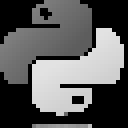

In [4]:
img_resized = imresize(image, 32, 32, method=Linear())
img_resized_gray = Gray.(img_resized)

In [5]:
size(img_resized_gray)

(32, 32)

In [6]:
#dct(img_resized_gray)
dct_image = dct(dct(reinterpret(UInt8, img_resized_gray),1),2);

In [7]:
hash_size = 8

8

In [8]:
dct_image[1:hash_size, 1:hash_size]

8×8 Matrix{Float64}:
  2895.19     -183.763   -1115.65    …   318.974      -38.346    206.469
    -7.80075  -129.368     423.53        -65.9429    -224.988     82.1788
 -1472.87      311.988    -331.356      -296.885      171.885   -118.643
   132.465     166.281    -779.363        -0.505716   326.005    -46.9618
   147.165    -199.134     289.929        11.8533     -16.3826   -37.8173
   -39.346      32.3416    105.482   …    30.695       33.8714   -49.644
   -58.4986     48.138     196.598        61.1268    -106.465     54.2435
   313.883     -41.1853    -56.6407      131.765     -277.581     66.4089

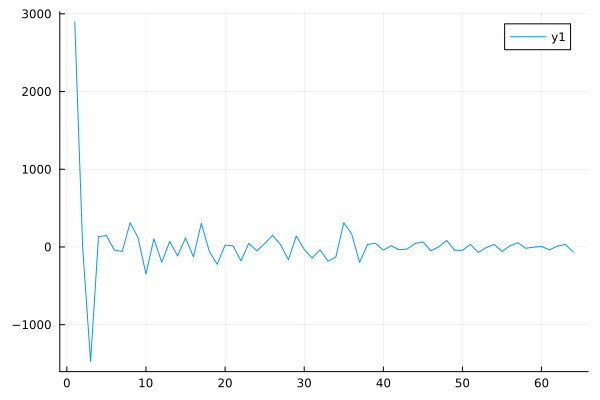

In [9]:
plot(dct_image[:][1:64])

In [13]:
mean(dct_image), maximum(dct_image), sum(dct_image)

(0.5103664526624767, 2895.1875000000005, 522.6152475263762)

In [14]:
plot

plot (generic function with 4 methods)

In [15]:
img_resized_gray[1]

In [16]:
channelview(img_resized_gray)

32×32 reinterpret(reshape, N0f8, ::Array{Gray{N0f8},2}) with eltype N0f8:
 0.0    0.0    0.0    0.0    0.0    0.0    …  0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0    …  0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.0    0.0       0.0    0.0    0.0    0.0    0.0
 0.0    0.0    0.0    0.0    0.49   0.482     0.886  0.0    0.0    0.0    0.0
 0.0    0.0    0.494  0.49   0.482  0.478     0.878  0.875  0.0    0.0    0.0
 0.0    0.494  0.49   0.486  0.478  0.471     0.875  0.871  0.867  0.0    0.0
 0.0    0.49   0.486  0.478  0.471  0.463  …  0.867  0.863  0.859  0.0    0.0
 0.49   0.486  0.478  0.471  0.463  0.455     0.859  0.855  0.855  0

In [17]:
Matrix{UInt8}

Matrix{UInt8} (alias for Array{UInt8, 2})

## Putting it all together

In [104]:

function preprocess_image(image, n_size_side_preprocess=32)
    img_resized = imresize(image, n_size_side_preprocess, n_size_side_preprocess)
    img_resized_gray = Gray.(img_resized)
    median_image_intensity = median(img_resized_gray).val
    return img_resized_gray, median_image_intensity
end

function perceptual_mathash(image, n_size_side=8; n_size_side_preprocess=32)
    img_resized_gray, median_image_intensity = preprocess_image(image, n_size_side_preprocess)
    #dct_image = dct(dct(reinterpret(UInt8, img_resized_gray),1),2);
    dct_image = dct(dct(reinterpret(UInt8, img_resized_gray),1),2);
    # option 1) Take the first n_size_side*n_size_side values
    #bit_matrix = dct_image[1:hash_size, 1:hash_size] .> median_image_intensity
    # option 2) Remove first term of dct
    bit_matrix = dct_image[1:n_size_side, 2:n_size_side+1] .> median_image_intensity
    return bit_matrix
end

perceptual_mathash (generic function with 2 methods)

In [105]:
img_resized_gray, median_image_intensity = preprocess_image(image)

(Gray{N0f8}[Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.0) Gray{N0f8}(0.0); Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.0) Gray{N0f8}(0.0); … ; Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.0) Gray{N0f8}(0.0); Gray{N0f8}(0.0) Gray{N0f8}(0.0) … Gray{N0f8}(0.0) Gray{N0f8}(0.0)], 0.39607844f0)

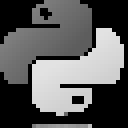

In [106]:
img_resized_gray

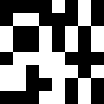

In [107]:
Gray.(perceptual_mathash(image))

In [119]:
dct_image = dct(dct(reinterpret(UInt8, img_resized_gray),1),2);

In [120]:
@btime dct_image = dct(dct(reinterpret(UInt8, img_resized_gray),1),2);

  35.959 μs (132 allocations: 32.75 KiB)


In [123]:
@btime dct(reinterpret(UInt8, img_resized_gray));

  38.042 μs (81 allocations: 21.66 KiB)


In [128]:
@btime dct(reinterpret(Float32, img_resized_gray));

  28.375 μs (92 allocations: 6.42 KiB)


In [145]:
@btime dct(Float32.(channelview(img_resized_gray)))

  38.792 μs (84 allocations: 13.48 KiB)


32×32 Matrix{Float32}:
 11.3537     -0.720639    -4.3751     …   0.0450257    0.341382
 -0.0305912  -0.507326     1.6609        -0.214301    -0.0492652
 -5.77595     1.22348     -1.29944       -0.0800702   -0.139636
  0.51947     0.652083    -3.05633        0.362778    -0.0231077
  0.577119   -0.780919     1.13698        0.0419931   -0.099237
 -0.154298    0.12683      0.413655   …  -0.139527    -0.207534
 -0.229406    0.188777     0.770972      -0.0911417    0.0826901
  1.23091    -0.161511    -0.222121       0.059485    -0.091432
  0.465567    0.0642248   -0.595561      -0.120274    -0.0756889
 -1.36833    -0.138028     0.805843      -0.100858     0.0360554
  0.416967   -0.104635    -0.239706   …   0.147469    -0.166508
 -0.776868    0.174823     0.0413108      0.12661     -0.0162699
  0.284925    0.256628    -0.834935      -0.0501938   -0.0172999
  ⋮                                   ⋱   ⋮           
  0.0578128  -0.0301269   -0.255345   …  -0.0050545   -0.152151
 -0.69796     0.130

In [146]:
@btime dct(dct(Float32.(channelview(img_resized_gray)),1),2)

  37.000 μs (135 allocations: 20.58 KiB)


32×32 Matrix{Float32}:
 11.3537     -0.720639    -4.3751     …   0.0450258    0.341382
 -0.0305912  -0.507326     1.6609        -0.214301    -0.0492652
 -5.77595     1.22348     -1.29944       -0.0800702   -0.139636
  0.51947     0.652083    -3.05633        0.362778    -0.0231077
  0.577119   -0.780919     1.13698        0.0419931   -0.099237
 -0.154298    0.12683      0.413655   …  -0.139527    -0.207534
 -0.229406    0.188777     0.770972      -0.0911417    0.0826901
  1.23091    -0.161511    -0.222121       0.059485    -0.091432
  0.465567    0.0642248   -0.595561      -0.120274    -0.0756889
 -1.36833    -0.138028     0.805843      -0.100858     0.0360554
  0.416967   -0.104635    -0.239706   …   0.147469    -0.166508
 -0.776868    0.174823     0.0413108      0.12661     -0.0162699
  0.284925    0.256628    -0.834935      -0.0501938   -0.0172999
  ⋮                                   ⋱   ⋮           
  0.0578128  -0.0301269   -0.255345   …  -0.0050545   -0.152151
 -0.69796     0.130

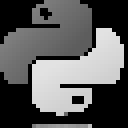

In [144]:
Gray.(Float32.(channelview(img_resized_gray)))

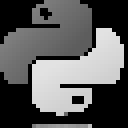

In [137]:
img_resized_gray

In [125]:
#[x for x in eachindex(dct_image_top_n_hash)]

In [115]:

function perceptual_hash(image, n_size_side=8)
    img_resized_gray, median_image_intensity = preprocess_image(image)
    dct_image = dct(dct(reinterpret(UInt8, img_resized_gray),1),2);
    # Option 1)
    #dct_image_view = view(dct_image,1:n_size_side, 2:n_size_side+1)
    #hash = reinterpret_bits_as_int_perceptual_hash(dct_image_view, median_image_intensity)
    # Option 2)
    #dct_image_view = view(dct_image,1:n_size_side, 2:n_size_side+1)
    dct_image_top_n_hash = dct_image[1:n_size_side, 2:n_size_side+1]
    hash = reinterpret_bits_as_int_perceptual_hash(dct_image_top_n_hash, median_image_intensity)
    return hash
end

function reinterpret_bits_as_int_perceptual_hash(img_resized_gray, median_image_intensity)

    n_bits = length(img_resized_gray)

    if n_bits <= 64
        z = zero(UInt64)
    elseif n_bits <= 128
        z = zero(UInt128)
    else
        z = zero(BigInt)
    end

    for k in eachindex(img_resized_gray)
        z = (z <<1) | (img_resized_gray[k] > median_image_intensity)
    end
    return z
end

reinterpret_bits_as_int_perceptual_hash (generic function with 1 method)

In [118]:
@btime perceptual_hash(image)

  56.291 μs (139 allocations: 39.62 KiB)


0x364e483d8f34c334

eachindex (generic function with 29 methods)

In [42]:

function perceptual_hash_slow(image, n_size_side=8; n_size_side_preprocess=32)
    bit_matrix = perceptual_mathash(image, n_size_side; n_size_side_preprocess=n_size_side_preprocess)
    hash = reinterpret_bits_as_int_perceptual_hash(bit_matrix.)
    return hash
end

LoadError: syntax: unexpected ")"

In [159]:
Float32.(channelview(img_resized_gray))

32×32 Matrix{Float32}:
 0.0       0.0       0.0       0.0       …  0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0       …  0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0       0.0
 0.0       0.0       0.0       0.0          0.0       0.0       0.0       0.0
 0.0       0.0       0.494118  0.490196     0.87451   0.0       0.0       0.0
 0.0       0.494118  0.490196  0.486275     0.870588  0.866667  0.0       0.0
 0.0       0.490196  0.486275  0.478431  …  0.862745  0.858824  0.0       0.0
 0.490196  0.486275  0.478431  0.470588     0.854902  0.854902  0.85098   0.0
 0.486275  0.478431  0.470588  0.462745  

In [161]:
dct(dct(reinterpret(UInt8, img_resized_gray),1),2)

32×32 Matrix{Float64}:
  2895.19     -183.763    -1115.65     …   84.0957    11.4815    87.0525
    -7.80075  -129.368      423.53         -3.06383  -54.6467   -12.5626
 -1472.87      311.988     -331.356       -22.0447   -20.4179   -35.6073
   132.465     166.281     -779.363        24.372     92.5083    -5.89247
   147.165    -199.134      289.929       -47.3995    10.7082   -25.3054
   -39.346      32.3416     105.482    …  -13.599    -35.5795   -52.9212
   -58.4986     48.138      196.598         7.35105  -23.2411    21.086
   313.883     -41.1853     -56.6407      -11.4261    15.1687   -23.3152
   118.719      16.3773    -151.868        30.7012   -30.6698   -19.3007
  -348.925     -35.1972     205.49        -36.0125   -25.7189     9.19414
   106.327     -26.682      -61.1251   …   16.4692    37.6045   -42.4595
  -198.101      44.5799      10.5342       -8.12146   32.2855    -4.14884
    72.6558     65.4401    -212.909       -12.8637   -12.7994    -4.41149
     ⋮                   

In [171]:
dct_image = dct(dct(Float32.(channelview(img_resized_gray)),1),2)

32×32 Matrix{Float32}:
 11.3537     -0.720639    -4.3751     …   0.0450258    0.341382
 -0.0305912  -0.507326     1.6609        -0.214301    -0.0492652
 -5.77595     1.22348     -1.29944       -0.0800702   -0.139636
  0.51947     0.652083    -3.05633        0.362778    -0.0231077
  0.577119   -0.780919     1.13698        0.0419931   -0.099237
 -0.154298    0.12683      0.413655   …  -0.139527    -0.207534
 -0.229406    0.188777     0.770972      -0.0911417    0.0826901
  1.23091    -0.161511    -0.222121       0.059485    -0.091432
  0.465567    0.0642248   -0.595561      -0.120274    -0.0756889
 -1.36833    -0.138028     0.805843      -0.100858     0.0360554
  0.416967   -0.104635    -0.239706   …   0.147469    -0.166508
 -0.776868    0.174823     0.0413108      0.12661     -0.0162699
  0.284925    0.256628    -0.834935      -0.0501938   -0.0172999
  ⋮                                   ⋱   ⋮           
  0.0578128  -0.0301269   -0.255345   …  -0.0050545   -0.152151
 -0.69796     0.130

In [154]:
?rawview

search: rawview



```
rawview(img::AbstractArray{FixedPoint})
```

returns a "view" of `img` where the values are interpreted in terms of their raw underlying storage. For example, if `img` is an `Array{N0f8}`, the view will act like an `Array{UInt8}`.

See also: [`normedview`](@ref)


## Note on DCT in FFTW vs Python

In [76]:
using FFTW, Statistics, ImageTransformations, Images
import ImageTransformations.Linear as Linear

In [2]:
?FFTW.dct

```
dct(A [, dims])
```

Performs a multidimensional type-II discrete cosine transform (DCT) of the array `A`, using the unitary normalization of the DCT. The optional `dims` argument specifies an iterable subset of dimensions (e.g. an integer, range, tuple, or array) to transform along.  Most efficient if the size of `A` along the transformed dimensions is a product of small primes; see [`nextprod`](@ref). See also [`plan_dct`](@ref) for even greater efficiency.


In [141]:
# Equivalent to python scipy.fftpack.dct([1,2,3], norm='ortho')
dct([1,2,3])

3-element Vector{Float64}:
  3.4641016151377544
 -1.414213562373095
  9.064933036736789e-17

In [78]:
import FFTW: dct
function dct_custom(x, dims = 1; norm = nothing)
    res = dct(x, dims)
    if norm == "ortho"
        res[1] = res[1] * 2 * sqrt(size(x, dims))
        res[2:end] = res[2:end] * sqrt(2 * size(x, dims))
    end
    res
end

dct_custom (generic function with 2 methods)

In [80]:
@btime dct_custom([1,2,3], norm="ortho")

  17.625 μs (76 allocations: 3.95 KiB)


3-element Vector{Float64}:
 11.999999999999998
 -3.464101615137754
  2.2204460492503128e-16

In [16]:
@btime dct([1,2,3])

  17.375 μs (68 allocations: 3.73 KiB)


3-element Vector{Float64}:
  3.4641016151377544
 -1.414213562373095
  9.064933036736789e-17

What would be the equivalent in 2d?

In [98]:
X = [[1,2,3] [4,5,6] [7, 8, 9]]

3×3 Matrix{Int64}:
 1  4  7
 2  5  8
 3  6  9

In [105]:
X[1:2,2:3]

2×2 Matrix{Int64}:
 4  7
 5  8

In [82]:
dct_custom(dct_custom(X,1,norm="ortho"),2,norm="ortho")

3×3 Matrix{Float64}:
 134.309        -38.0031  3.51472
 -14.6969         0.0     0.0
   9.42055e-16    0.0     0.0

In [83]:
dct(dct(X,1),2)

3×3 Matrix{Float64}:
 15.0          -7.34847  -3.62597e-16
 -2.44949       0.0       0.0
  1.57009e-16   0.0       0.0

In [50]:
dct_custom(X,1,norm="ortho")

3×3 Matrix{Float64}:
 12.0          21.2132       33.9411
 -3.4641       -3.4641       -3.4641
  2.22045e-16   2.22045e-16   2.22045e-16

In [44]:
dct_custom(X,2,norm="ortho")

3×3 Matrix{Float64}:
 24.0     -10.3923  8.88178e-16
 21.2132  -10.3923  8.88178e-16
 25.4558  -10.3923  8.88178e-16

In [19]:
?dct

search: dct dct! idct idct! Dict plan_dct plan_dct! plan_idct plan_idct! IdDict



```
dct(A [, dims])
```

Performs a multidimensional type-II discrete cosine transform (DCT) of the array `A`, using the unitary normalization of the DCT. The optional `dims` argument specifies an iterable subset of dimensions (e.g. an integer, range, tuple, or array) to transform along.  Most efficient if the size of `A` along the transformed dimensions is a product of small primes; see [`nextprod`](@ref). See also [`plan_dct`](@ref) for even greater efficiency.


In [4]:
dct([[1,3,4,4,5] [1,2,3,4,5]])

5×2 Matrix{Float64}:
 10.1193      0.632456
 -4.1912      0.262866
 -0.58541    -0.58541
 -0.826948   -0.425325
  0.0854102   0.0854102

In [5]:
[[1,3,4,4,5] [1,2,3,4,5]]

5×2 Matrix{Int64}:
 1  1
 3  2
 4  3
 4  4
 5  5

In [6]:
dct([1,2,3])

3-element Vector{Float64}:
  3.4641016151377544
 -1.414213562373095
  9.064933036736789e-17

In [10]:
dct_image_ortho = dct_custom(dct_custom(reinterpret(UInt8, img_resized_gray),1, norm="orthogonal"),2,norm="orthogonal");

LoadError: UndefVarError: dct_custom not defined

In [11]:
plot(dct_image_ortho[:][1:100])

LoadError: UndefVarError: dct_image_ortho not defined

In [12]:
plot(dct_image_ortho[1:8,2:9][:])
#plot(dct_image_ortho[2:9,1:9][:])

LoadError: UndefVarError: dct_image_ortho not defined